# Predicting Pulsar Stars from Radio Wave Emission Spectrum.
We take a [pulsar star dataset](https://www.kaggle.com/pavanraj159/predicting-a-pulsar-star) from Kraggle. This dataset includes 17,898 radio wave emission spectrum profiles, out of which 1,639 are from pulsar stars, and rest are induced by radio frequency interference and noise. This calls for a model that is robust against noise (regularization).

In this dataset, each datapoint has eight features, on which we try to train a vanilla model that predicts if a radio emission spectrum is from a pulsar star. We will use the least square method and LASSO, and compare the result of their prediction as well as the sparsity of the model.

In [43]:
using LinearAlgebra
using CSV, DataFrames
using Plots
using LaTeXStrings

In [4]:
df = CSV.File("pulsar_stars.csv", header=1) |> DataFrame

,Mean of the integrated profile,Standard deviation of the integrated profile
,Float64,Float64
1,140.563,55.6838
2,102.508,58.8824
3,103.016,39.3416
4,136.75,57.1784
5,88.7266,40.6722
6,93.5703,46.6981
7,119.484,48.7651
8,130.383,39.8441
9,107.25,52.6271


In [5]:
labels = df[:, end] .* 2.0 .- 1.0 # 1 if the spectrum is from a pulsar star, -1 otherwise.
A = Matrix(df[:, 1:end-1])
m, n = size(A)

# remove the mean and normalize the variance.
A = (I - ones(m, m) / m) * A
for j = 1:n; A[:, j] = LinearAlgebra.normalize(A[:, j]); end 

## Linear Least Square
First recall the linear least squares from the example in class. Notice how $x = R^{-1} Q^T b$ is implemented to avoid a matrix inversion, although Julia is smart enough to optimize for you no matter how you write it. 

In [53]:
function ls_qr(A::Array{Float64,2}, b::Vector{Float64})::Array{Float64, 1}
    Q, R = qr(A)
    return R \ (Matrix(Q)' * b)
end

ls_qr (generic function with 1 method)

In [54]:
x = ls_qr(A, labels);

In [55]:
function eval_prediction(x)
    global A, labels
    prediction = map((e) -> e > 0 ? 1.0 : -1.0, A * x)
    false_negative, false_positive = (sum(prediction .< labels), sum(prediction .> labels))
end

eval_prediction (generic function with 1 method)

In [56]:
println(eval_prediction(x))

(76, 3173)


We see that this vanilla classifier fits reasonably well in terms of false negatives, but the parameters of the models are quite large.

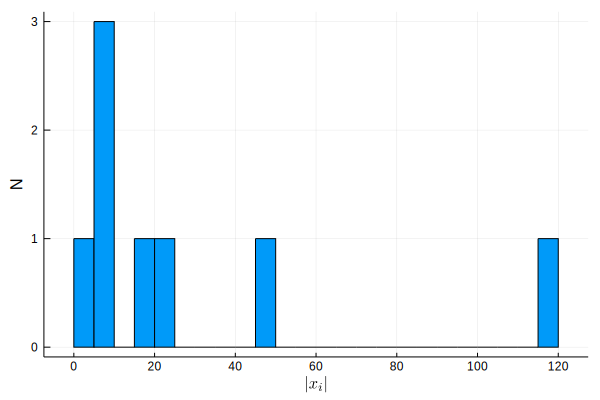

In [51]:
histogram(abs.(x), bins=0:5:120, xlabel="\$|x_i|\$", ylabel="N", label="")

## LASSO
We can use LASSO to increase sparsity. We will this with iterative soft threshholding. The procedure is very straightforward to code up.

In [35]:
function isda(A::Array{Float64, 2}, b::Array{Float64, 1}, λ::Float64)::Array{Float64, 1}
        τ = 1.0 / norm(A)^2
        (_, n) = size(A)
        w = zeros(n)
        for _ = 1:1e6
                z = w - τ * (A'*(A*w-b))
                w_old = w
                w = sign.(z) .* max.(abs.(z) .- τ*λ/2, 0)
                if norm(w-w_old) < 1e-5; break; end
        end
        return w
end

isda (generic function with 1 method)

In [36]:
x = isda(A, labels, 2.5);

In [37]:
print(eval_prediction(x))

(85, 2788)

Notice that our have more false negatives than in the least square case, but we now have a more compact model.

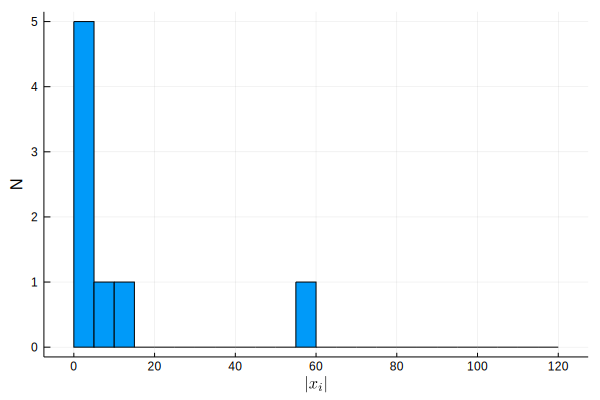

In [48]:
histogram(abs.(x), bins=0:5:120, xlabel="\$|x_i|\$", ylabel="N", label="")